# Analyzing the Firefox Engineering Workflow Data

In [1]:
import pandas as pd
import seaborn as sns

In [24]:
df = pd.read_parquet('data/nightly-20190122094123.parq')

In [25]:
df.head()

,changeset,changeset_pushid,changeset_desc,bug_id,nightly_build_id,nightly_publish_time,changeset_pushtime,bug_creation_time
1,d532474e710f8a58ab10a2702dca432bc2eefa69,35411,Bug 1519107 - make evaluateJS calls use promis...,1519107,20190122094123,2019-01-22 12:16:52,2019-01-22 03:53:40,2019-01-10 14:32:35
2,c367b5259d4683c8d7fcf7efdda68f6ca93f9913,35411,Bug 1519107 - use promise pattern for getCache...,1519107,20190122094123,2019-01-22 12:16:52,2019-01-22 03:53:40,2019-01-10 14:32:35
3,05ab29790c5718f31d2910f8728af5f742eaf14d,35411,Bug 1519107 - use promise pattern for other we...,1519107,20190122094123,2019-01-22 12:16:52,2019-01-22 03:53:40,2019-01-10 14:32:35
4,f833d5220c821a2c19c60c6ac5378c677bebbe71,35411,Bug 1521279 - Update Fluent migration document...,1521279,20190122094123,2019-01-22 12:16:52,2019-01-22 03:53:40,2019-01-19 08:11:08
5,88b4f92e2197c7478923e9d399adb62ed6f415ef,35411,Bug 1521518 - Update image to 0.21 r=kats\n\nD...,1521518,20190122094123,2019-01-22 12:16:52,2019-01-22 03:53:40,2019-01-21 14:28:56


*Lead Time* is the total time a work item is in process, including the time up-front when we are waiting for work to start.

We will assume that the bug creation time is when the work was queued but not started (or started very soon after).

In [26]:
df['lead_time'] = df['nightly_publish_time'] - df['bug_creation_time']

In [27]:
df['lead_time'].max()

Timedelta('1998 days 17:26:33')

Clean up some of our outliers.

In [30]:
lead_time_s = df['lead_time'].dt.total_seconds().rolling(3).mean()

In [31]:
lead_time_s = lead_time_s.dropna()

In [37]:
df['lead_time'].describe()

count                          88
mean      79 days 13:47:19.465909
std      259 days 15:49:24.295934
min               0 days 08:23:13
25%        3 days 17:54:17.250000
50%       12 days 01:12:54.500000
75%              54 days 00:41:27
max            1998 days 17:26:33
Name: lead_time, dtype: object

In [39]:
df['lead_time'].max().total_seconds()

172689993.0

In [40]:
lead_time_s.max()

58807094.333333336

In [45]:
lead_time_days = lead_time_s / ((3600) * 24)

Text(0.5, 0, 'lead time (days)')

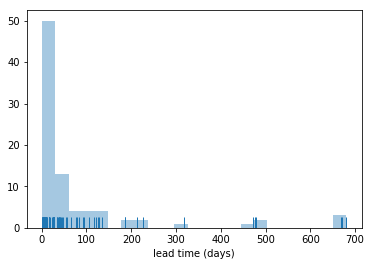

In [46]:
g = sns.distplot(lead_time_days, kde=False, rug=True)
g.set_xlabel("lead time (days)")

In [47]:
lead_time_days.describe(percentiles=[0.25, 0.5, 0.75, 0.90, 0.95])

count     86.000000
mean      80.785528
std      149.858849
min        0.772728
25%        7.737283
50%       25.235002
75%       74.349691
90%      199.255559
95%      474.789171
max      680.637666
Name: lead_time, dtype: float64

Let's grab the landings within one standard deviation of the mean to see what a typical timeline looks like.

In [48]:
durations = lead_time_days.where(lead_time_days < (lead_time_days.mean() + lead_time_days.std()))
durations = durations.dropna()
durations.describe()

count     79.000000
mean      40.290048
std       50.980747
min        0.772728
25%        7.293765
50%       24.540822
75%       44.434149
max      226.259171
Name: lead_time, dtype: float64

Text(0.5, 0, 'lead time (days)')

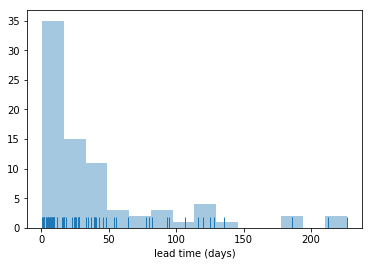

In [49]:
g = sns.distplot(durations, kde=False, rug=True)
g.set_xlabel("lead time (days)")